## 🧬🔍 Features Engineer and Anomaly Detected

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df_cleanwdrop = pd.read_csv('../dataset/cleanedwdrop_sales_data.csv')
df_cleanwfill = pd.read_csv('../dataset/cleanedwfill_sales_data.csv')

In [2]:
for df in [df_cleanwdrop, df_cleanwfill]:
    df["posting_date"] = pd.to_datetime(df["posting_date"], errors="coerce", utc=True)
    df['price'] = df['price'].astype(int)

In [3]:
df_cleanwdrop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79193 entries, 0 to 79192
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   region        79193 non-null  object             
 1   price         79193 non-null  int64              
 2   year          79193 non-null  float64            
 3   manufacturer  79193 non-null  object             
 4   model         79193 non-null  object             
 5   condition     79193 non-null  object             
 6   cylinders     79193 non-null  object             
 7   fuel          79193 non-null  object             
 8   odometer      79193 non-null  float64            
 9   title_status  79193 non-null  object             
 10  transmission  79193 non-null  object             
 11  drive         79193 non-null  object             
 12  size          79193 non-null  object             
 13  type          79193 non-null  object             
 14  paint_

In [4]:
# Extract year, month, and day from 'posting_date' and calculate 'car_age' for both datasets
for df in [df_cleanwdrop, df_cleanwfill]:
    df["posting_year"] = pd.to_datetime(df["posting_date"]).dt.year
    df["posting_month"] = pd.to_datetime(df["posting_date"]).dt.month
    df["posting_day"] = pd.to_datetime(df["posting_date"]).dt.day
    df["car_age"] = df["posting_year"] - df["year"]
    df.drop(columns=["posting_date"], inplace=True)

In [5]:
for name, df in [("df_cleanwfill", df_cleanwfill), ("df_cleanwdrop", df_cleanwdrop)]:
    print(f'Number of cars that have a car_age <= 0 in {name} >> {len(df[df["car_age"] <= 0])}')
    df = df[df["car_age"] > 0]

    print(f'Number of "parts only" cars in {name} >> {len(df[df["title_status"] == "parts only"])}')
    df = df[df["title_status"] != "parts only"]

    # Update the original variable
    if name == "df_cleanwfill":
        df_cleanwfill = df
    else:
        df_cleanwdrop = df


Number of cars that have a car_age <= 0 in df_cleanwfill >> 2122
Number of "parts only" cars in df_cleanwfill >> 109
Number of cars that have a car_age <= 0 in df_cleanwdrop >> 180
Number of "parts only" cars in df_cleanwdrop >> 46


## 🧹📉 Outlier Removal

In [6]:
for name, df in [("df_cleanwdrop", df_cleanwdrop), ("df_cleanwfill", df_cleanwfill)]:
    print(f"✅ Max price ({name}):", df["price"].max())
    print(f"✅ Min price ({name}):", df["price"].min())

✅ Max price (df_cleanwdrop): 3736928711
✅ Min price (df_cleanwdrop): 0
✅ Max price (df_cleanwfill): 3736928711
✅ Min price (df_cleanwfill): 0


In [7]:
for name, df in [("df_cleanwdrop", df_cleanwdrop), ("df_cleanwfill", df_cleanwfill)]:
    df = df[(df["price"] > 0) & (df["odometer"] > 0)]
    if name == "df_cleanwdrop":
        df_cleanwdrop = df
    else:
        df_cleanwfill = df

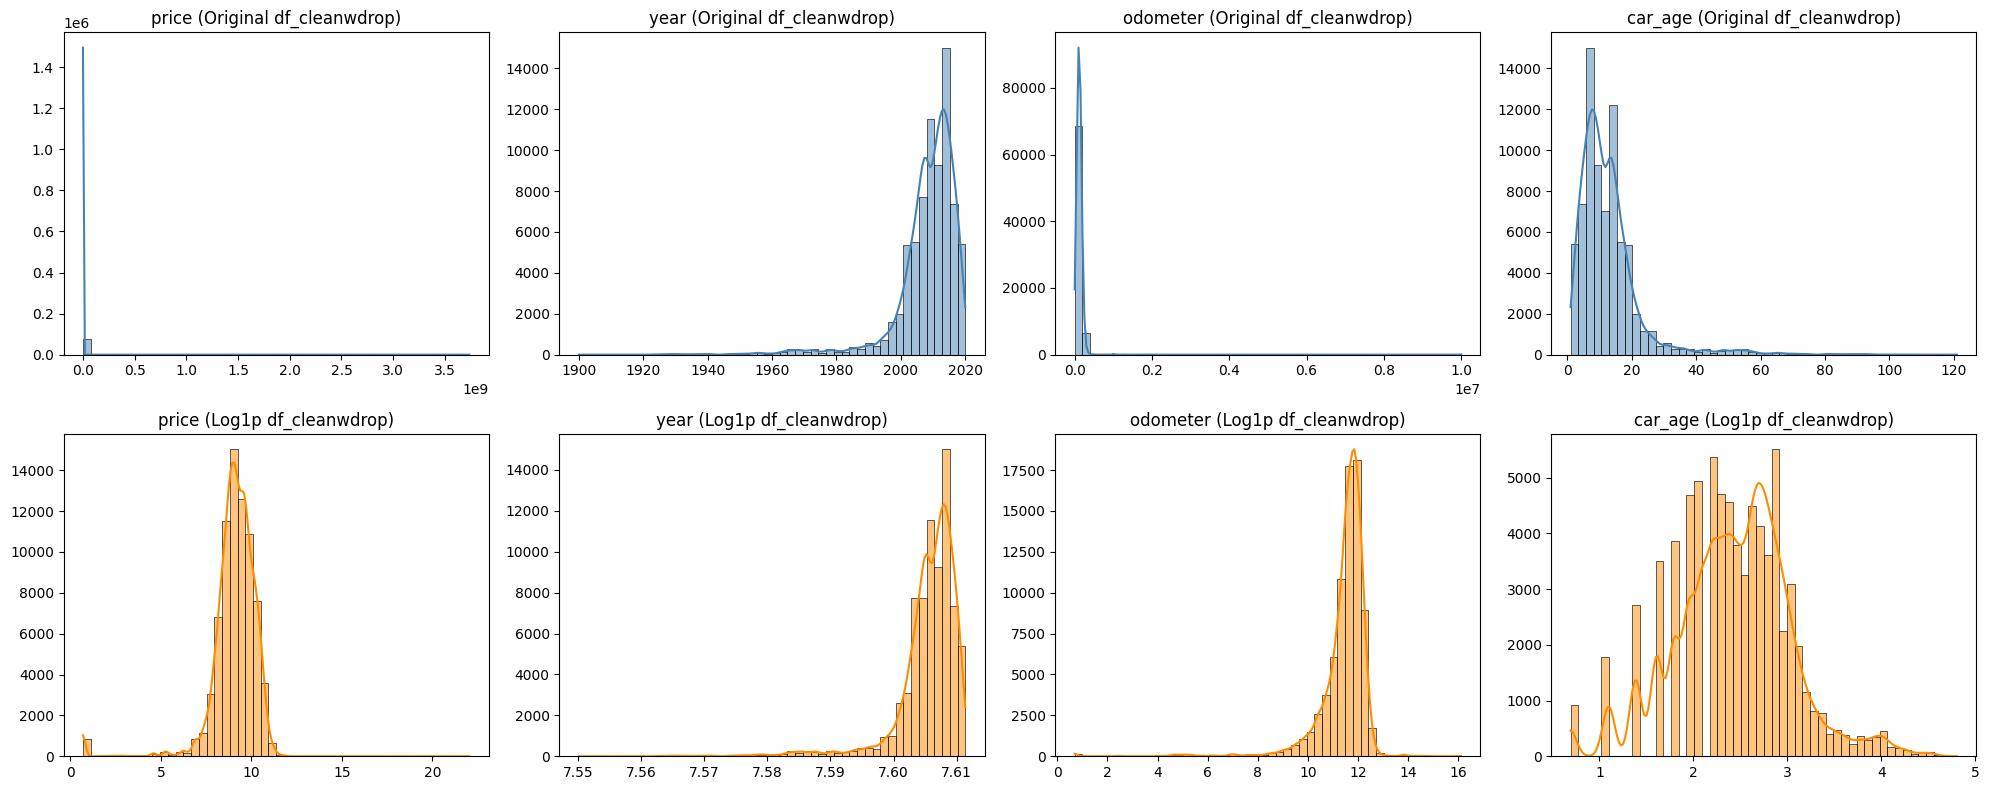

In [8]:
import seaborn as sns

import matplotlib.pyplot as plt
cols = ['price', 'year', 'odometer', 'car_age']

plt.figure(figsize=(20, 8))

for i, col in enumerate(cols):
    plt.subplot(2, len(cols), i + 1)
    sns.histplot(df_cleanwdrop[col], bins=50, kde=True, color='steelblue', edgecolor='black')
    plt.title(f'{col} (Original df_cleanwdrop)')
    plt.xlabel("")
    plt.ylabel("")

# Second row: log1p transformed (just an example; customize as needed)
for i, col in enumerate(cols):
    plt.subplot(2, len(cols), i + 1 + len(cols))
    sns.histplot(np.log1p(df_cleanwdrop[col]), bins=50, kde=True, color='darkorange', edgecolor='black')
    plt.title(f'{col} (Log1p df_cleanwdrop)')
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()

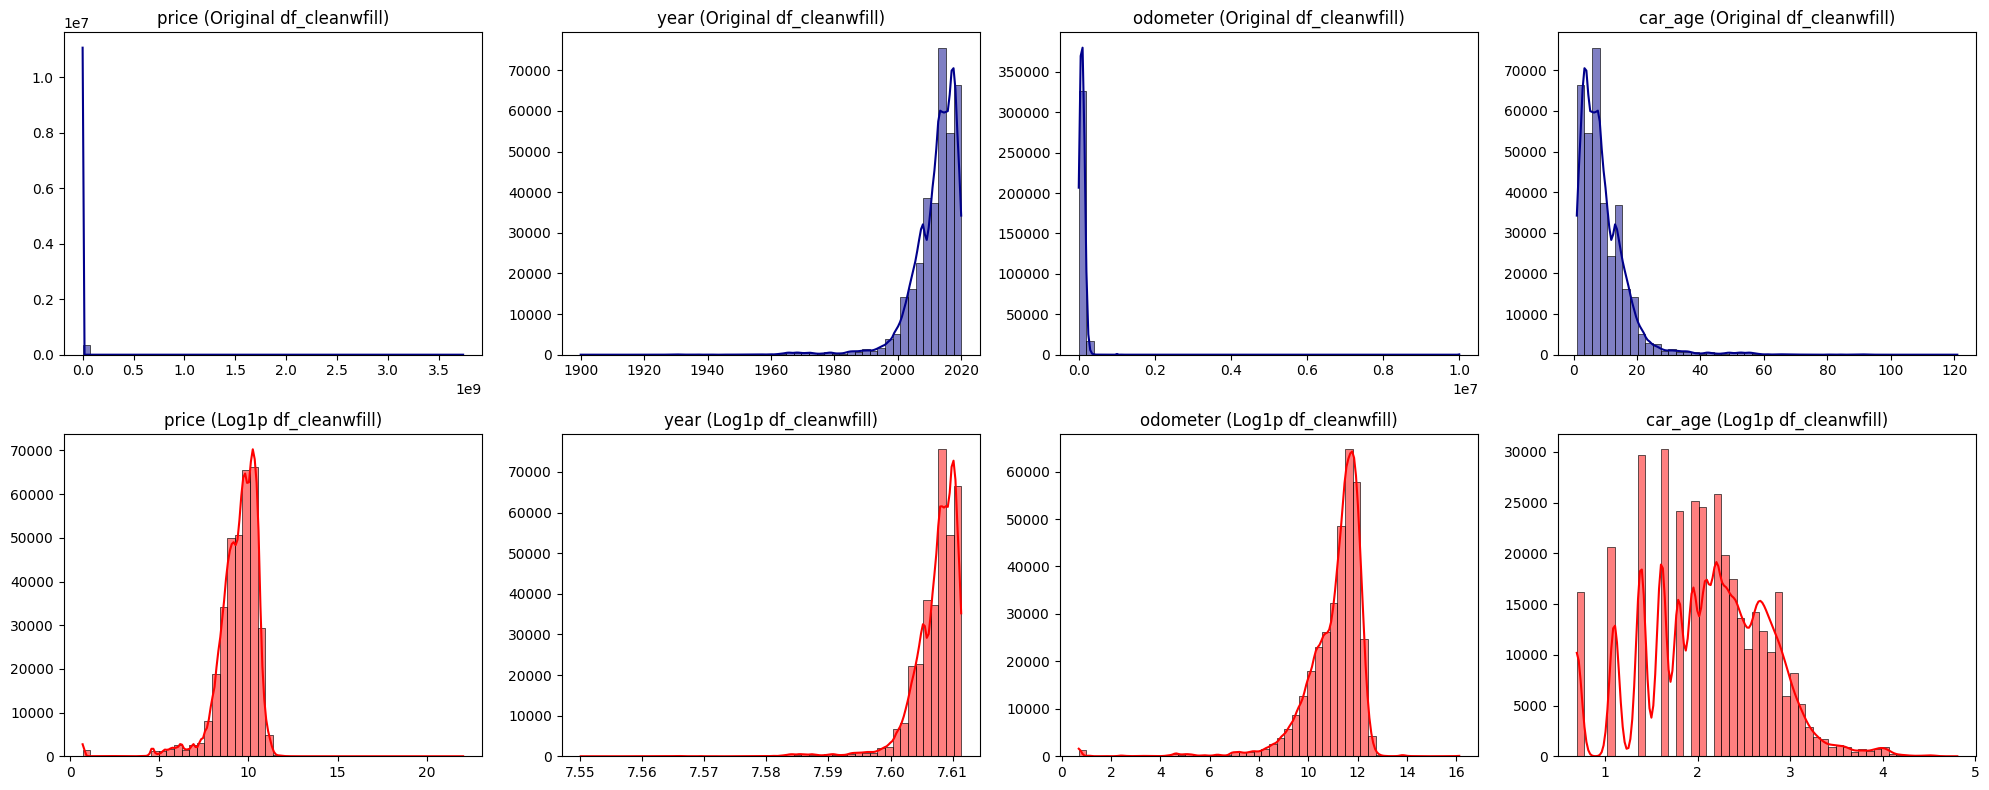

In [9]:
plt.figure(figsize=(20, 8))

for i, col in enumerate(cols):
    plt.subplot(2, len(cols), i + 1)
    sns.histplot(df_cleanwfill[col], bins=50, kde=True, color='darkblue', edgecolor='black')
    plt.title(f'{col} (Original df_cleanwfill)')
    plt.xlabel("")
    plt.ylabel("")

# Second row: log1p transformed (just an example; customize as needed)
for i, col in enumerate(cols):
    plt.subplot(2, len(cols), i + 1 + len(cols))
    sns.histplot(np.log1p(df_cleanwfill[col]), bins=50, kde=True, color='red', edgecolor='black')
    plt.title(f'{col} (Log1p df_cleanwfill)')
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()

### Outlier Removal IQR + log transformation

In [10]:
def clean_and_log_iqr(df, df_name):
    df_log = df.copy()
    cols_to_clean = ['price', 'odometer']

    for col in cols_to_clean:
        df_log[col] = np.log1p(df_log[col])  # Log transform
        Q1 = df_log[col].quantile(0.25)
        Q3 = df_log[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f"[{df_name} - {col}] IQR bounds:")
        print(f"  → lower: {np.expm1(lower_bound):,.2f}")
        print(f"  → upper: {np.expm1(upper_bound):,.2f}")

        # Filter
        df_log = df_log[(df_log[col] >= lower_bound) & (df_log[col] <= upper_bound)]

        # Inverse transform
        df_log[col] = np.expm1(df_log[col])

    print(f"✅ Final cleaned dataset ({df_name}): {df_log.shape[0]} rows remaining")
    return df_log


# Apply to both DataFrames
df_cleanwdrop_log = clean_and_log_iqr(df_cleanwdrop, "df_cleanwdrop")
df_cleanwfill_log = clean_and_log_iqr(df_cleanwfill, "df_cleanwfill")


[df_cleanwdrop - price] IQR bounds:
  → lower: 926.58
  → upper: 106,626.66
[df_cleanwdrop - odometer] IQR bounds:
  → lower: 25,596.33
  → upper: 466,150.50
✅ Final cleaned dataset (df_cleanwdrop): 68787 rows remaining
[df_cleanwfill - price] IQR bounds:
  → lower: 928.55
  → upper: 202,599.53
[df_cleanwfill - odometer] IQR bounds:
  → lower: 6,310.06
  → upper: 848,158.78
✅ Final cleaned dataset (df_cleanwfill): 320530 rows remaining


In [11]:
def apply_iqr_filter(df, df_name, cols_to_filter):
    for col in cols_to_filter:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f"[{df_name} - {col}] IQR bounds: {lower_bound:.2f} to {upper_bound:.2f}")
        before = df.shape[0]
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after = df.shape[0]
        print(f"→ Removed {before - after} rows from '{col}'")

    print(f"✅ Final cleaned dataset ({df_name}): {df.shape[0]} rows remaining")
    return df


# Apply IQR filtering (no log transform) to both datasets
cols_to_filter = ['year', 'car_age']
df_cleanwdrop_log = apply_iqr_filter(df_cleanwdrop_log, "df_cleanwdrop_log", cols_to_filter)
df_cleanwfill_log = apply_iqr_filter(df_cleanwfill_log, "df_cleanwfill_log", cols_to_filter)


[df_cleanwdrop_log - year] IQR bounds: 1991.50 to 2027.50
→ Removed 2676 rows from 'year'
[df_cleanwdrop_log - car_age] IQR bounds: -5.00 to 27.00
→ Removed 389 rows from 'car_age'
✅ Final cleaned dataset (df_cleanwdrop_log): 65722 rows remaining
[df_cleanwfill_log - year] IQR bounds: 1994.50 to 2030.50
→ Removed 7418 rows from 'year'
[df_cleanwfill_log - car_age] IQR bounds: -8.00 to 24.00
→ Removed 1716 rows from 'car_age'
✅ Final cleaned dataset (df_cleanwfill_log): 311396 rows remaining


### 🌲Isolation Forest

In [12]:
from sklearn.ensemble import IsolationForest

In [13]:
df_cleanwdrop_iso = df_cleanwdrop.copy()

df_cleanwfill_iso = df_cleanwfill.copy()

In [14]:
iso = IsolationForest(contamination=0.02, random_state=42)
# Apply Isolation Forest for anomaly detection on selected columns
columns_to_check = ['price', 'odometer', 'year', 'car_age']

for col in columns_to_check:
    df_cleanwdrop_iso = df_cleanwdrop_iso[iso.fit_predict(df_cleanwdrop_iso[[col]]) == 1]
    df_cleanwfill_iso = df_cleanwfill_iso[iso.fit_predict(df_cleanwfill_iso[[col]]) == 1]


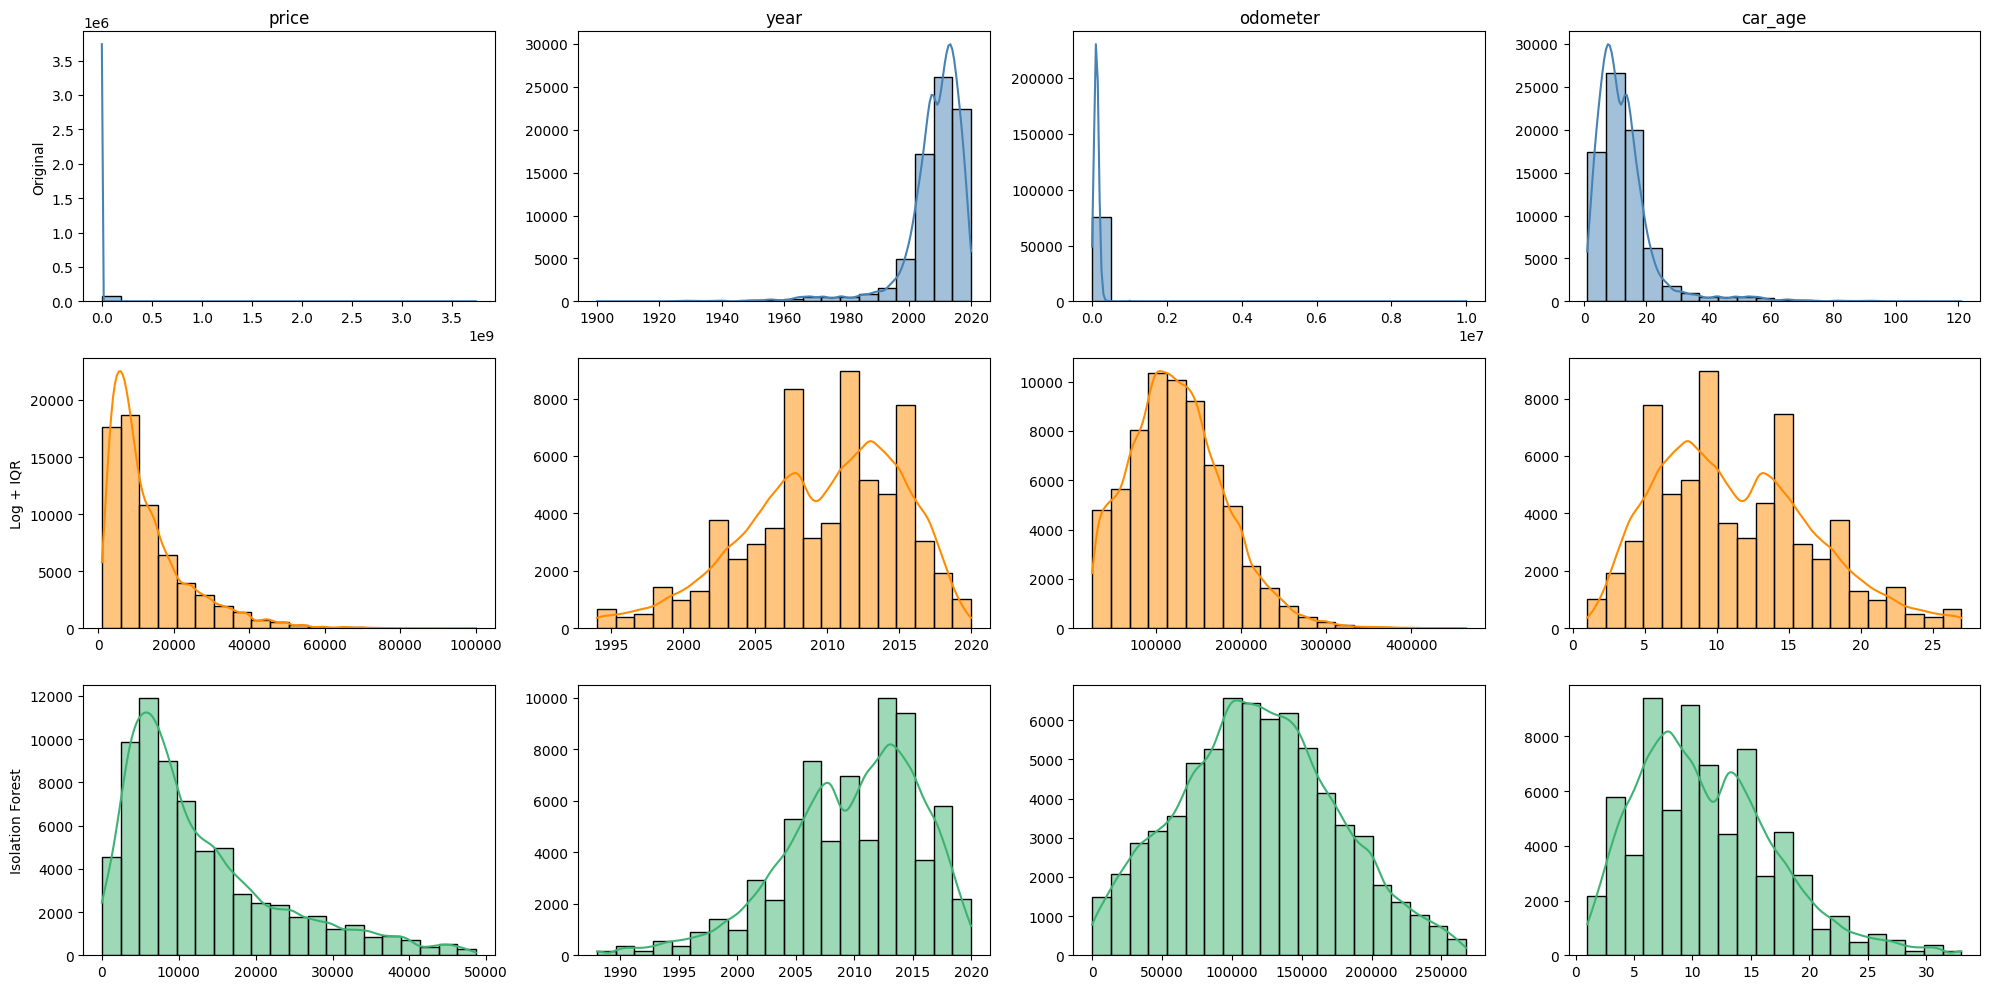

In [15]:
cols = ['price', 'year', 'odometer', 'car_age']
datasets = {
    "Original": df_cleanwdrop,
    "Log + IQR": df_cleanwdrop_log,
    "Isolation Forest": df_cleanwdrop_iso
}
colors = ['steelblue', 'darkorange', 'mediumseagreen']

plt.figure(figsize=(20, 10))

for row, (label, df) in enumerate(datasets.items()):
    for i, col in enumerate(cols):
        plt.subplot(len(datasets), len(cols), row * len(cols) + i + 1)
        sns.histplot(df[col], bins=20, kde=True, color=colors[row], edgecolor='black')
        if row == 0:
            plt.title(col)
        if i == 0:
            plt.ylabel(label)
        else:
            plt.ylabel("")
        plt.xlabel("")

plt.tight_layout()
plt.show()

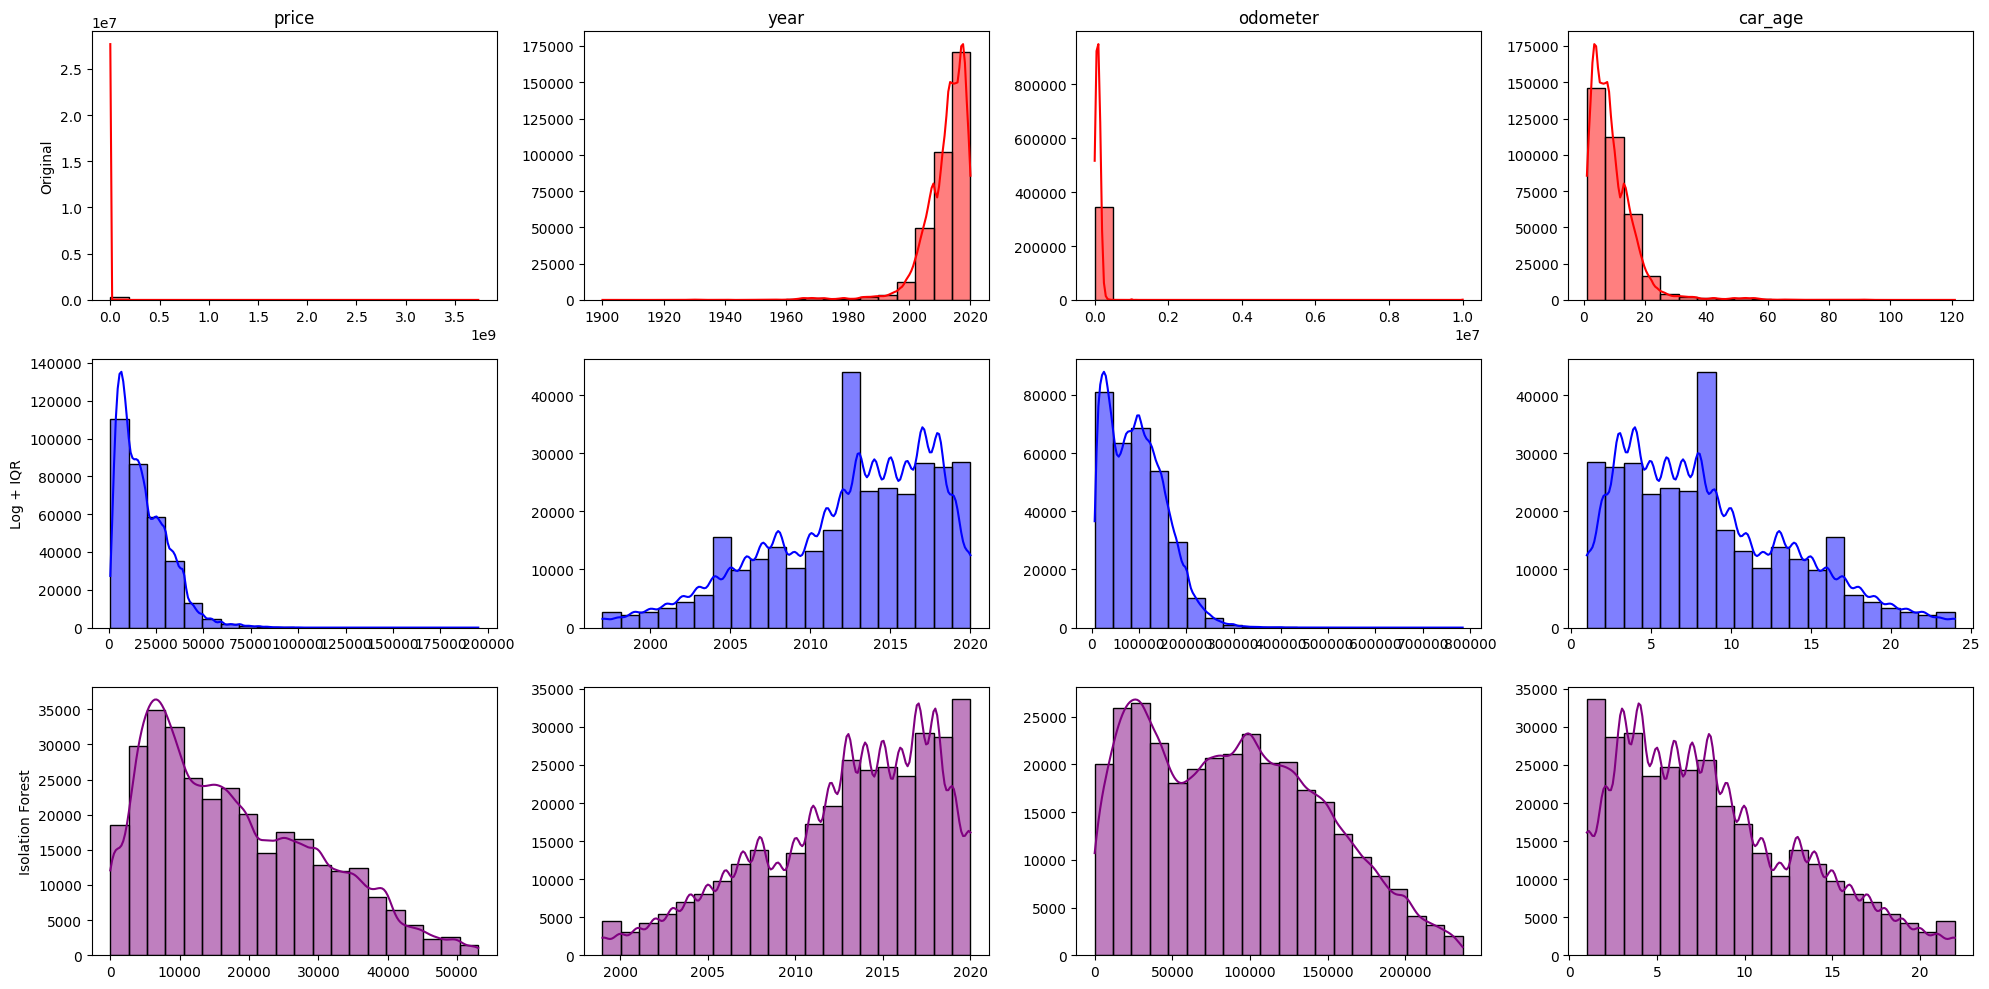

In [16]:
cols = ['price', 'year', 'odometer', 'car_age']
datasets = {
    "Original": df_cleanwfill,
    "Log + IQR": df_cleanwfill_log,
    "Isolation Forest": df_cleanwfill_iso
}
colors = ['red', 'blue', 'purple']

plt.figure(figsize=(20, 10))

for row, (label, df) in enumerate(datasets.items()):
    for i, col in enumerate(cols):
        plt.subplot(len(datasets), len(cols), row * len(cols) + i + 1)
        sns.histplot(df[col], bins=20, kde=True, color=colors[row], edgecolor='black')
        if row == 0:
            plt.title(col)
        if i == 0:
            plt.ylabel(label)
        else:
            plt.ylabel("")
        plt.xlabel("")

plt.tight_layout()
plt.show()

## 📚Features Engineer (Clustering)

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from kneed import KneeLocator
from scipy.stats import boxcox

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [18]:
# Common feature columns
feature_cols = ['year', 'odometer', 'condition', 'cylinders', 'fuel', 'title_status',
                'transmission', 'drive', 'type', 'size', 'car_age']

# Dictionary of input and output names
datasets = {
    "feat_df_cleanwfill_log": df_cleanwfill_log,
    "feat_df_cleanwdrop_log": df_cleanwdrop_log,
    "feat_df_cleanwfill_iso": df_cleanwfill_iso,
    "feat_df_cleanwdrop_iso": df_cleanwdrop_iso
}

# Extract selected features
for name, df in datasets.items():
    globals()[name] = df[feature_cols].copy()


In [19]:
def normalize(df):
    # Ensure all values are positive for Box-Cox transformation
    df['odometer'], _ = boxcox(df['odometer'])
    df['car_age'], _ = boxcox(df['car_age'])
    df['year'] = np.log1p(df['year'])
    return df

feat_df_cleanwfill_log = normalize(feat_df_cleanwfill_log)
feat_df_cleanwdrop_log = normalize(feat_df_cleanwdrop_log)
feat_df_cleanwfill_iso = normalize(feat_df_cleanwfill_iso)
feat_df_cleanwdrop_iso = normalize(feat_df_cleanwdrop_iso)

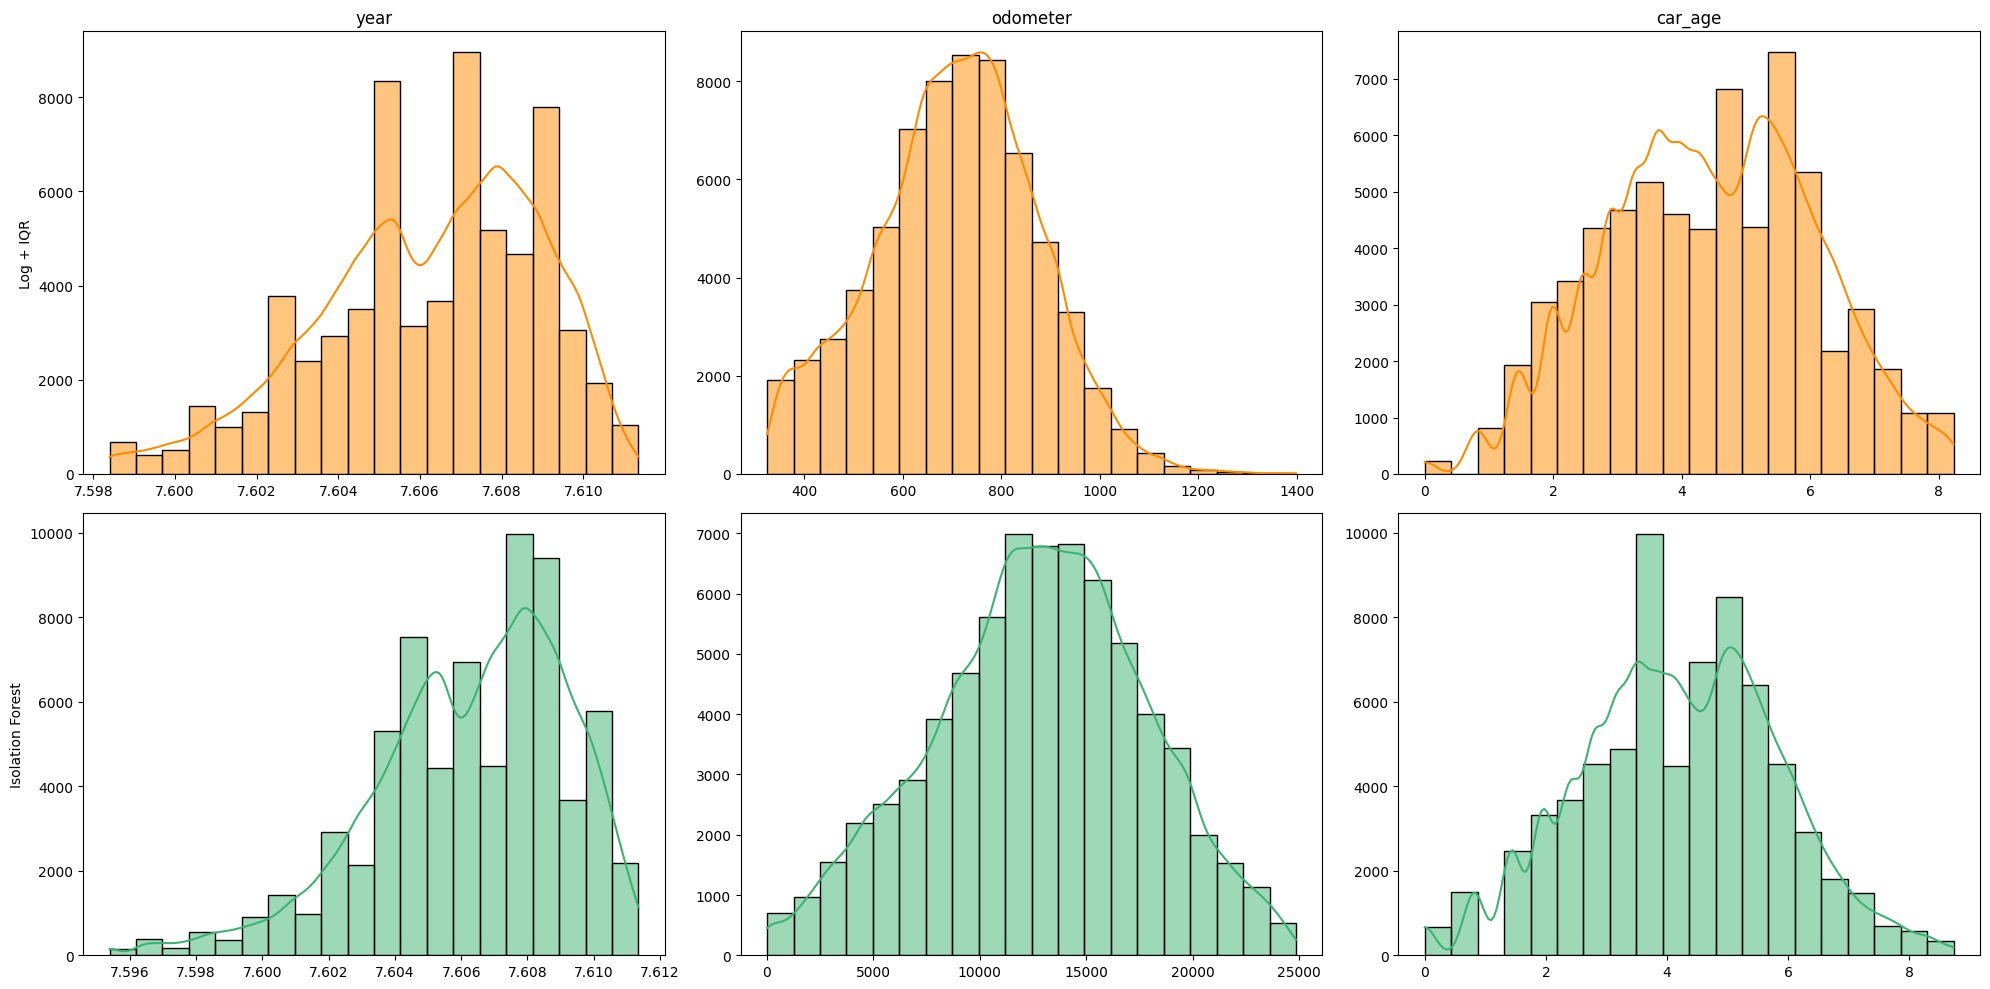

In [20]:
cols = ['year', 'odometer', 'car_age']
datasets = {
    "Log + IQR": feat_df_cleanwdrop_log,
    "Isolation Forest": feat_df_cleanwdrop_iso
}
colors = ['darkorange', 'mediumseagreen']

plt.figure(figsize=(20, 10))

for row, (label, df) in enumerate(datasets.items()):
    for i, col in enumerate(cols):
        plt.subplot(len(datasets), len(cols), row * len(cols) + i + 1)
        sns.histplot(df[col], bins=20, kde=True, color=colors[row])
        if row == 0:
            plt.title(col)
        if i == 0:
            plt.ylabel(label)
        else:
            plt.ylabel("")
        plt.xlabel("")

plt.tight_layout()
plt.show()

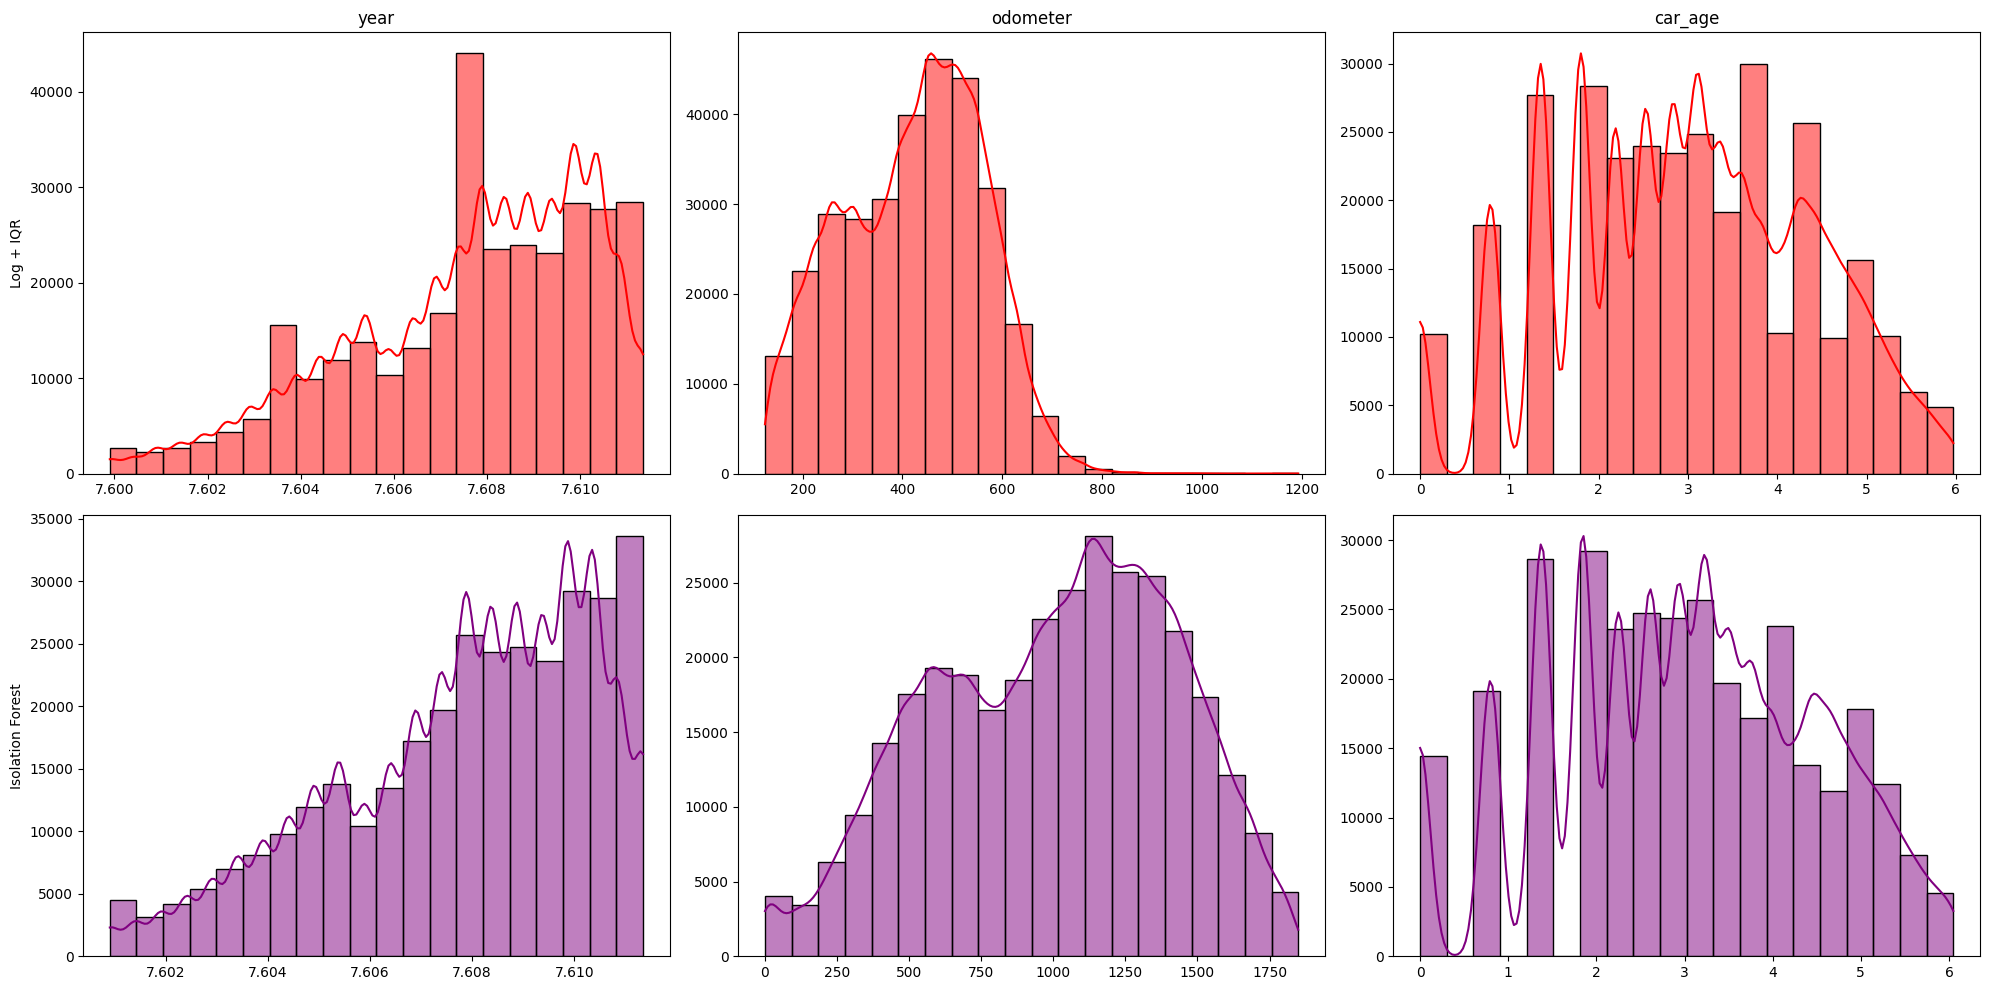

In [21]:
cols = ['year', 'odometer', 'car_age']
datasets = {
    "Log + IQR": feat_df_cleanwfill_log,
    "Isolation Forest": feat_df_cleanwfill_iso
}
colors = ['red', 'purple']

plt.figure(figsize=(20, 10))

for row, (label, df) in enumerate(datasets.items()):
    for i, col in enumerate(cols):
        plt.subplot(len(datasets), len(cols), row * len(cols) + i + 1)
        sns.histplot(df[col], bins=20, kde=True, color=colors[row])
        if row == 0:
            plt.title(col)
        if i == 0:
            plt.ylabel(label)
        else:
            plt.ylabel("")
        plt.xlabel("")

plt.tight_layout()
plt.show()

In [22]:
# Define the mapping
title_status_mapping = {
    'clean': 5,
    'rebuilt': 4,
    'lien': 3,
    'salvage': 2,
    'missing': 1,
    'parts only': 0
}

condition_mapping = {
    'excellent': 5,
    'like new': 4,
    'good': 3,
    'fair': 2,
    'new': 1,
    'salvage': 0
}

cylinder_mapping = {
    '3 cylinders': 3,
    '4 cylinders': 4,
    '5 cylinders': 5,
    '6 cylinders': 6,
    '8 cylinders': 8,
    '10 cylinders': 10,
    '12 cylinders': 12,
    'other': 0
}

# Apply the mapping to the 'title_status' column
for df in [feat_df_cleanwdrop_log, feat_df_cleanwdrop_iso]:
    df['title_status'] = df['title_status'].map(title_status_mapping).fillna(5).astype('int64')
    df['condition'] = df['condition'].map(condition_mapping).fillna(5).astype('int64')
    df['cylinders'] = df['cylinders'].map(cylinder_mapping).fillna(6).astype('int64')


for df in [feat_df_cleanwfill_log, feat_df_cleanwfill_iso]:
    df['title_status'] = df['title_status'].map(title_status_mapping).fillna(5).astype('int64')
    df['condition'] = df['condition'].map(condition_mapping).fillna(5).astype('int64')


In [23]:
# List of DataFrames to process
dataframes = [feat_df_cleanwdrop_log, feat_df_cleanwfill_log, feat_df_cleanwdrop_iso, feat_df_cleanwfill_iso]

for df in dataframes:
    # Select categorical columns
    categorical_cols = df.select_dtypes(include='object').columns
    
    # Apply LabelEncoder to each categorical column
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [24]:
sc = StandardScaler()
mm = MinMaxScaler()

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Initialize the scaler
mm = MinMaxScaler()

# List of input DataFrames and their names
input_dfs = {
    "cleanwdrop_log": feat_df_cleanwdrop_log,
    "cleanwfill_log": feat_df_cleanwfill_log,
    "cleanwdrop_iso": feat_df_cleanwdrop_iso,
    "cleanwfill_iso": feat_df_cleanwfill_iso,
}

# Output storage
scaled_dfs = {}
centered_dfs = {}
cov_matrices = {}
eigenvalues = {}
eigenvectors = {}

# Processing loop
for name, df in input_dfs.items():
    # Min-Max scaling
    scaled = mm.fit_transform(df)
    scaled_df = pd.DataFrame(scaled, columns=df.columns)
    scaled_dfs[name] = scaled_df

    # Mean centering
    centered = scaled_df - scaled_df.mean()
    centered_dfs[name] = centered

    # Covariance matrix
    cov_matrix = np.cov(centered, rowvar=False)
    cov_matrices[name] = cov_matrix

    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eig(cov_matrix)
    eigenvalues[name] = eigvals
    eigenvectors[name] = eigvecs


In [25]:
for name, eigvals in eigenvalues.items():
    print(f"\n🔍 PVES for: {name}")
    total_variance_scaler = np.sum(eigvals)
    total = 0
    for i, v in enumerate(eigvals):
        total += v * 100 / total_variance_scaler
        print("PVES {} : {:.2f} % | Cumulative : {:.2f} %".format(i, v * 100 / total_variance_scaler, total))



🔍 PVES for: cleanwdrop_log
PVES 0 : 30.67 % | Cumulative : 30.67 %
PVES 1 : 20.84 % | Cumulative : 51.51 %
PVES 2 : 17.06 % | Cumulative : 68.57 %
PVES 3 : 9.25 % | Cumulative : 77.83 %
PVES 4 : 6.92 % | Cumulative : 84.75 %
PVES 5 : 0.09 % | Cumulative : 84.84 %
PVES 6 : 4.05 % | Cumulative : 88.89 %
PVES 7 : 2.32 % | Cumulative : 91.21 %
PVES 8 : 2.52 % | Cumulative : 93.73 %
PVES 9 : 2.88 % | Cumulative : 96.61 %
PVES 10 : 3.39 % | Cumulative : 100.00 %

🔍 PVES for: cleanwfill_log
PVES 0 : 26.95 % | Cumulative : 26.95 %
PVES 1 : 21.26 % | Cumulative : 48.20 %
PVES 2 : 14.12 % | Cumulative : 62.32 %
PVES 3 : 11.28 % | Cumulative : 73.60 %
PVES 4 : 10.05 % | Cumulative : 83.65 %
PVES 5 : 7.29 % | Cumulative : 90.94 %
PVES 6 : 4.06 % | Cumulative : 94.99 %
PVES 7 : 0.23 % | Cumulative : 95.23 %
PVES 8 : 1.97 % | Cumulative : 97.20 %
PVES 9 : 1.31 % | Cumulative : 98.51 %
PVES 10 : 1.49 % | Cumulative : 100.00 %

🔍 PVES for: cleanwdrop_iso
PVES 0 : 30.06 % | Cumulative : 30.06 %
PVES 1

In [26]:
from sklearn.decomposition import PCA

# Apply PCA with 9 components to log-scaled datasets
pca_log_cleanwdrop = PCA(n_components=8)
X_log_reduced_cleanwdrop = pca_log_cleanwdrop.fit_transform(scaled_dfs['cleanwdrop_log'])

pca_log_cleanwfill = PCA(n_components=6)
X_log_reduced_cleanwfill = pca_log_cleanwfill.fit_transform(scaled_dfs['cleanwfill_log'])

# Apply PCA with 8 components to ISO-scaled datasets
pca_iso_cleanwdrop = PCA(n_components=7)
X_iso_reduced_cleanwdrop = pca_iso_cleanwdrop.fit_transform(scaled_dfs['cleanwdrop_iso'])

pca_iso_cleanwfill = PCA(n_components=7)
X_iso_reduced_cleanwfill = pca_iso_cleanwfill.fit_transform(scaled_dfs['cleanwfill_iso'])

✅ Best number of clusters (elbow): 22


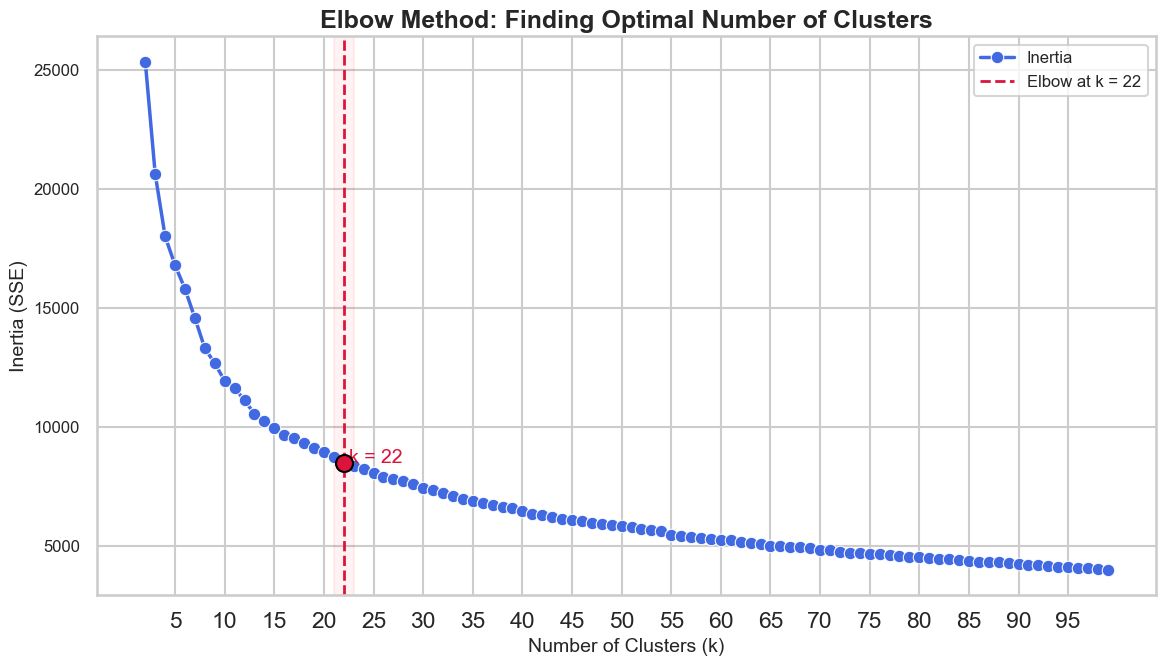

In [27]:
inertias = []
k_values = range(2, 100)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_log_reduced_cleanwdrop)
    inertias.append(km.inertia_)

kneedle = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
best_k = kneedle.elbow

print(f"✅ Best number of clusters (elbow): {best_k}")

sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(12, 7))
sns.lineplot(x=k_values, y=inertias, marker="o", linewidth=2.5, color="royalblue", label="Inertia")
plt.scatter(best_k, inertias[best_k - k_values[0]], s=150, color="crimson", edgecolor="black", zorder=10)
plt.axvline(best_k, color="crimson", linestyle="--", linewidth=2, label=f"Elbow at k = {best_k}")
plt.axvspan(best_k - 1, best_k + 1, color='red', alpha=0.05)
plt.text(best_k + 0.5, inertias[best_k - k_values[0]], f"k = {best_k}", color="crimson", fontsize=14)

plt.title("Elbow Method: Finding Optimal Number of Clusters", fontsize=18, weight='bold')
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Inertia (SSE)", fontsize=14)
plt.xticks(k_values)
plt.yticks(fontsize=12)
step = 5
plt.xticks(ticks=[k for k in k_values if k % step == 0])
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

✅ Best number of clusters (elbow): 23


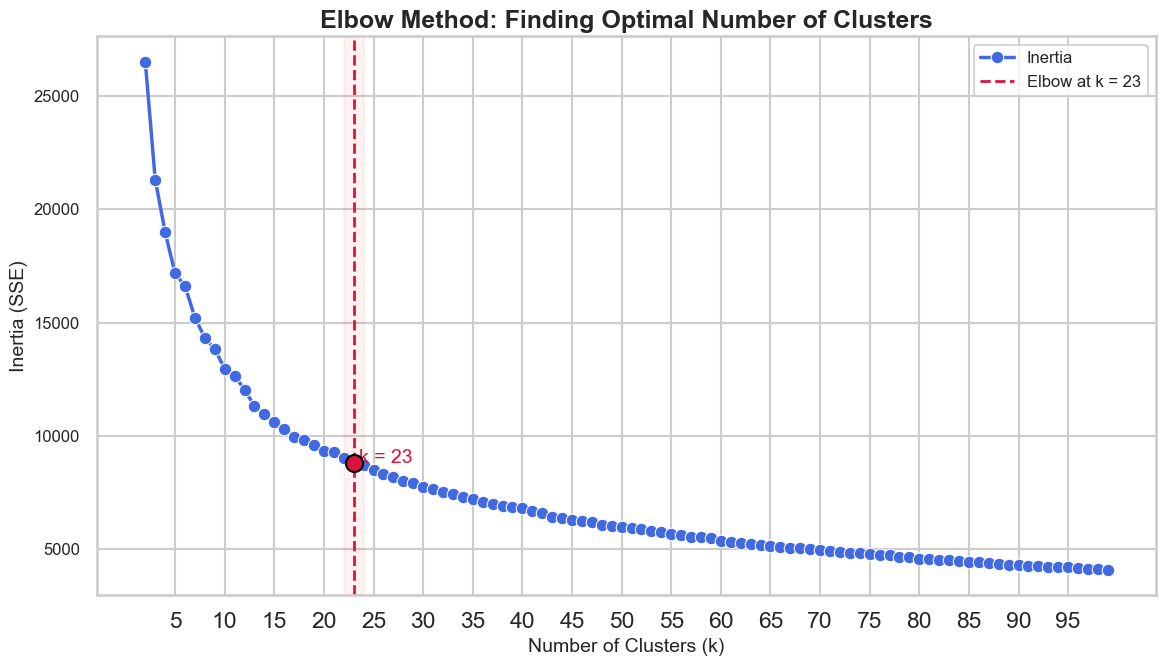

In [28]:
inertias = []
k_values = range(2, 100)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_iso_reduced_cleanwdrop)
    inertias.append(km.inertia_)

kneedle = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
best_k = kneedle.elbow

print(f"✅ Best number of clusters (elbow): {best_k}")

sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(12, 7))
sns.lineplot(x=k_values, y=inertias, marker="o", linewidth=2.5, color="royalblue", label="Inertia")
plt.scatter(best_k, inertias[best_k - k_values[0]], s=150, color="crimson", edgecolor="black", zorder=10)
plt.axvline(best_k, color="crimson", linestyle="--", linewidth=2, label=f"Elbow at k = {best_k}")
plt.axvspan(best_k - 1, best_k + 1, color='red', alpha=0.05)
plt.text(best_k + 0.5, inertias[best_k - k_values[0]], f"k = {best_k}", color="crimson", fontsize=14)

plt.title("Elbow Method: Finding Optimal Number of Clusters", fontsize=18, weight='bold')
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Inertia (SSE)", fontsize=14)
plt.xticks(k_values)
plt.yticks(fontsize=12)
step = 5
plt.xticks(ticks=[k for k in k_values if k % step == 0])
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

✅ Best number of clusters (elbow): 25


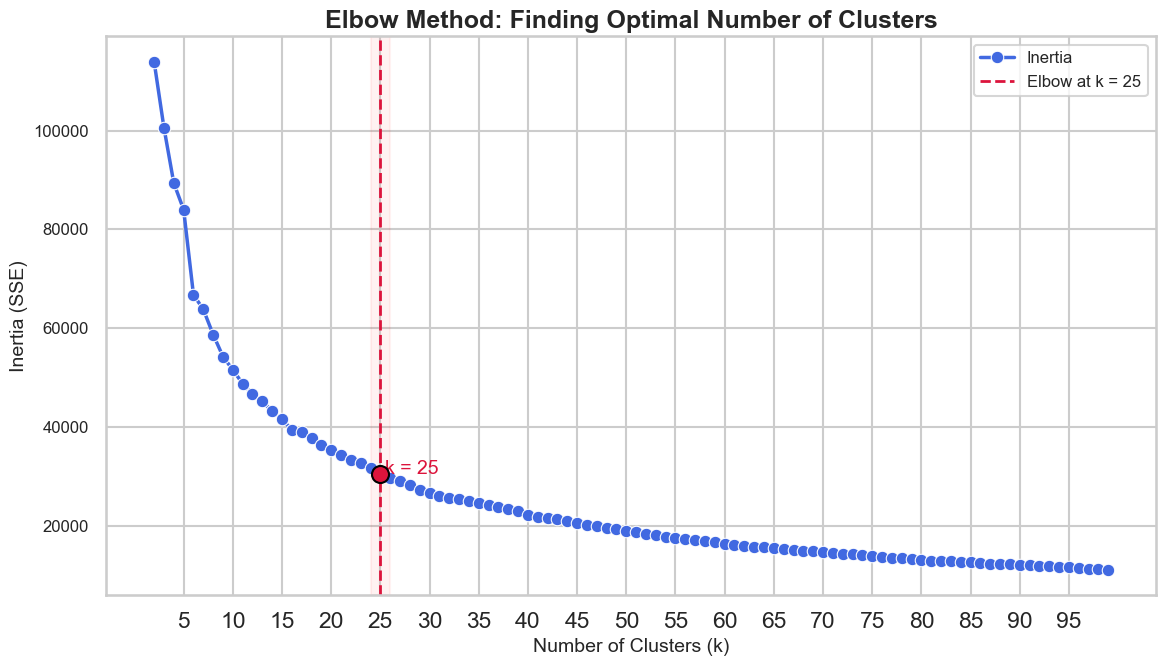

In [29]:
inertias = []
k_values = range(2, 100)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_log_reduced_cleanwfill)
    inertias.append(km.inertia_)

kneedle = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
best_k = kneedle.elbow

print(f"✅ Best number of clusters (elbow): {best_k}")

sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(12, 7))
sns.lineplot(x=k_values, y=inertias, marker="o", linewidth=2.5, color="royalblue", label="Inertia")
plt.scatter(best_k, inertias[best_k - k_values[0]], s=150, color="crimson", edgecolor="black", zorder=10)
plt.axvline(best_k, color="crimson", linestyle="--", linewidth=2, label=f"Elbow at k = {best_k}")
plt.axvspan(best_k - 1, best_k + 1, color='red', alpha=0.05)
plt.text(best_k + 0.5, inertias[best_k - k_values[0]], f"k = {best_k}", color="crimson", fontsize=14)

plt.title("Elbow Method: Finding Optimal Number of Clusters", fontsize=18, weight='bold')
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Inertia (SSE)", fontsize=14)
plt.xticks(k_values)
plt.yticks(fontsize=12)
step = 5
plt.xticks(ticks=[k for k in k_values if k % step == 0])
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

✅ Best number of clusters (elbow): 21


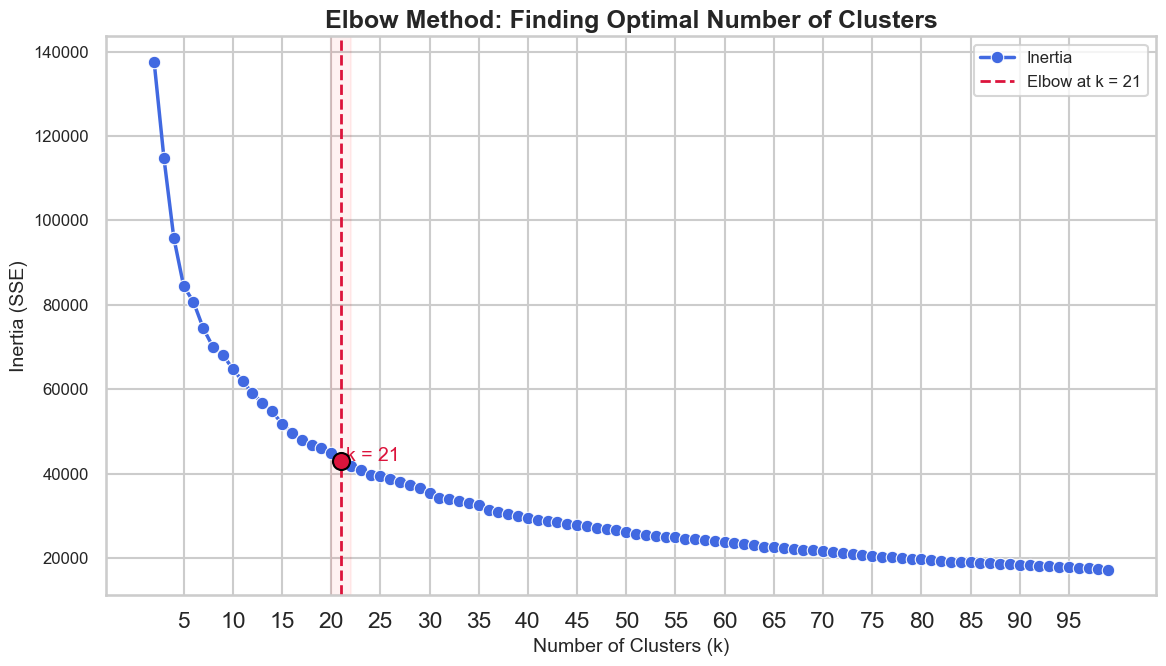

In [30]:
inertias = []
k_values = range(2, 100)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_iso_reduced_cleanwfill)
    inertias.append(km.inertia_)

kneedle = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
best_k = kneedle.elbow

print(f"✅ Best number of clusters (elbow): {best_k}")

sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(12, 7))
sns.lineplot(x=k_values, y=inertias, marker="o", linewidth=2.5, color="royalblue", label="Inertia")
plt.scatter(best_k, inertias[best_k - k_values[0]], s=150, color="crimson", edgecolor="black", zorder=10)
plt.axvline(best_k, color="crimson", linestyle="--", linewidth=2, label=f"Elbow at k = {best_k}")
plt.axvspan(best_k - 1, best_k + 1, color='red', alpha=0.05)
plt.text(best_k + 0.5, inertias[best_k - k_values[0]], f"k = {best_k}", color="crimson", fontsize=14)

plt.title("Elbow Method: Finding Optimal Number of Clusters", fontsize=18, weight='bold')
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Inertia (SSE)", fontsize=14)
plt.xticks(k_values)
plt.yticks(fontsize=12)
step = 5
plt.xticks(ticks=[k for k in k_values if k % step == 0])
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

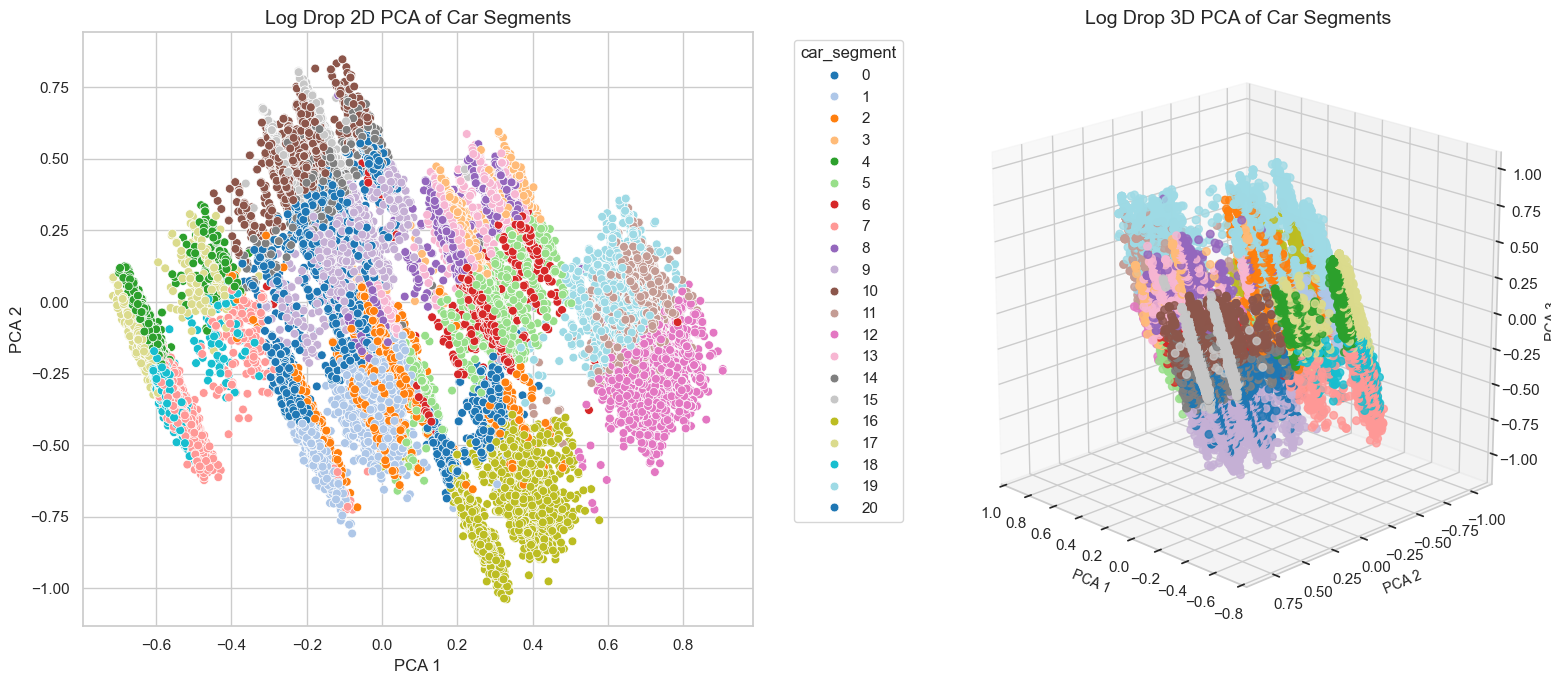

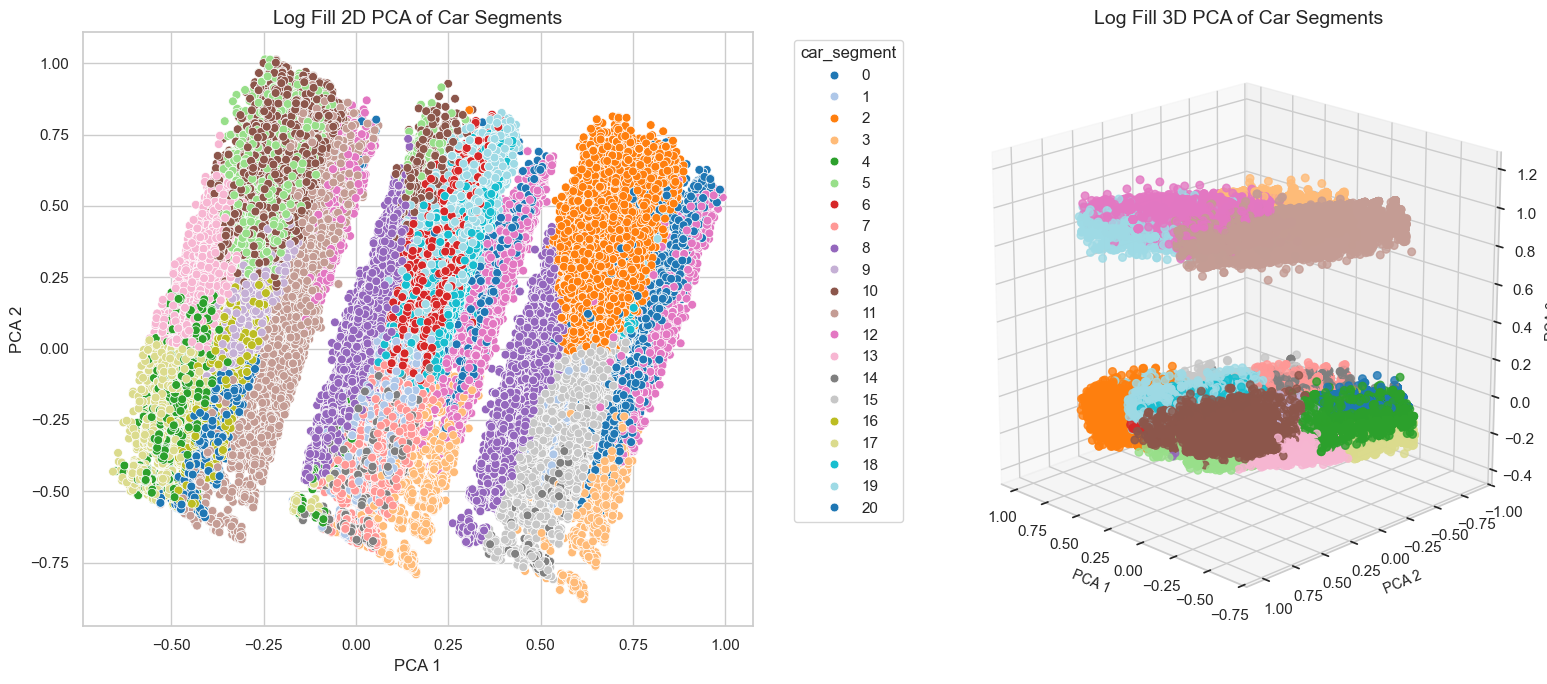

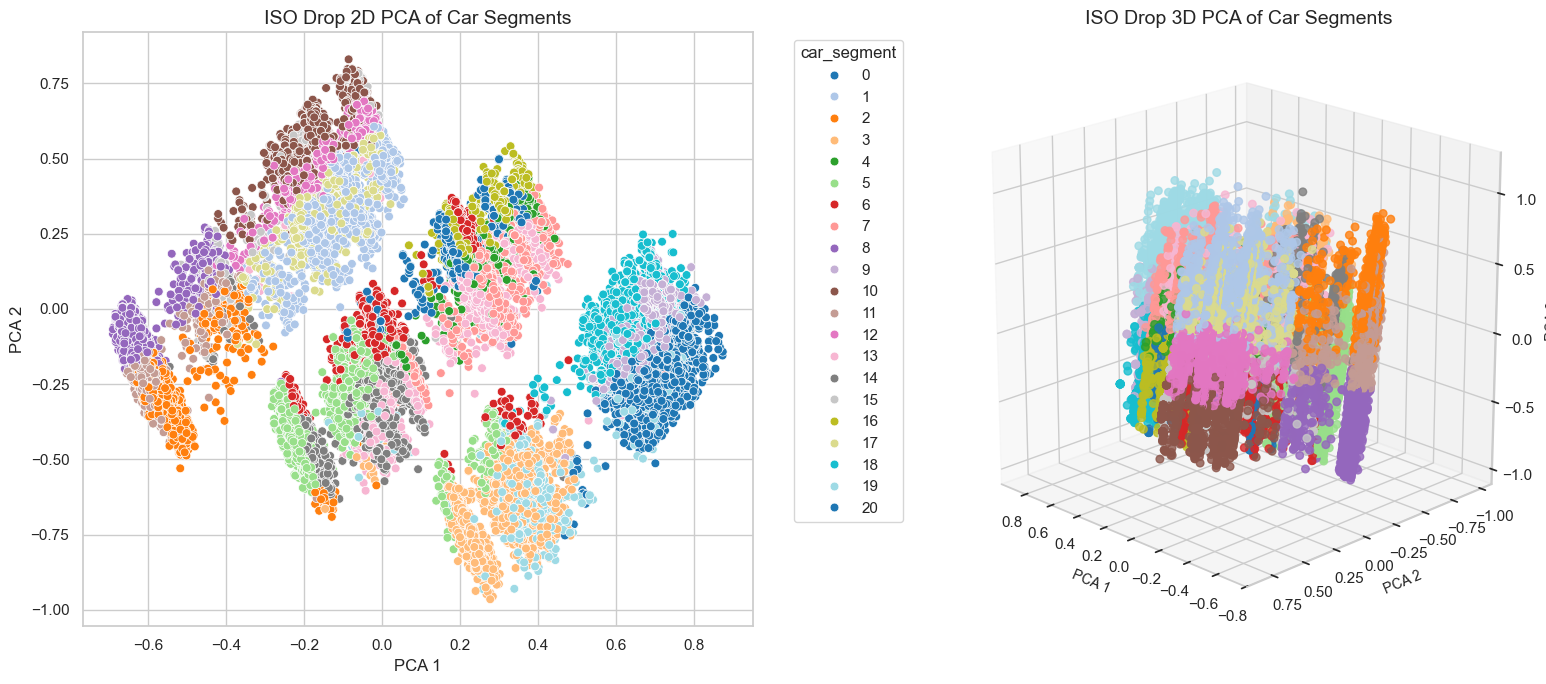

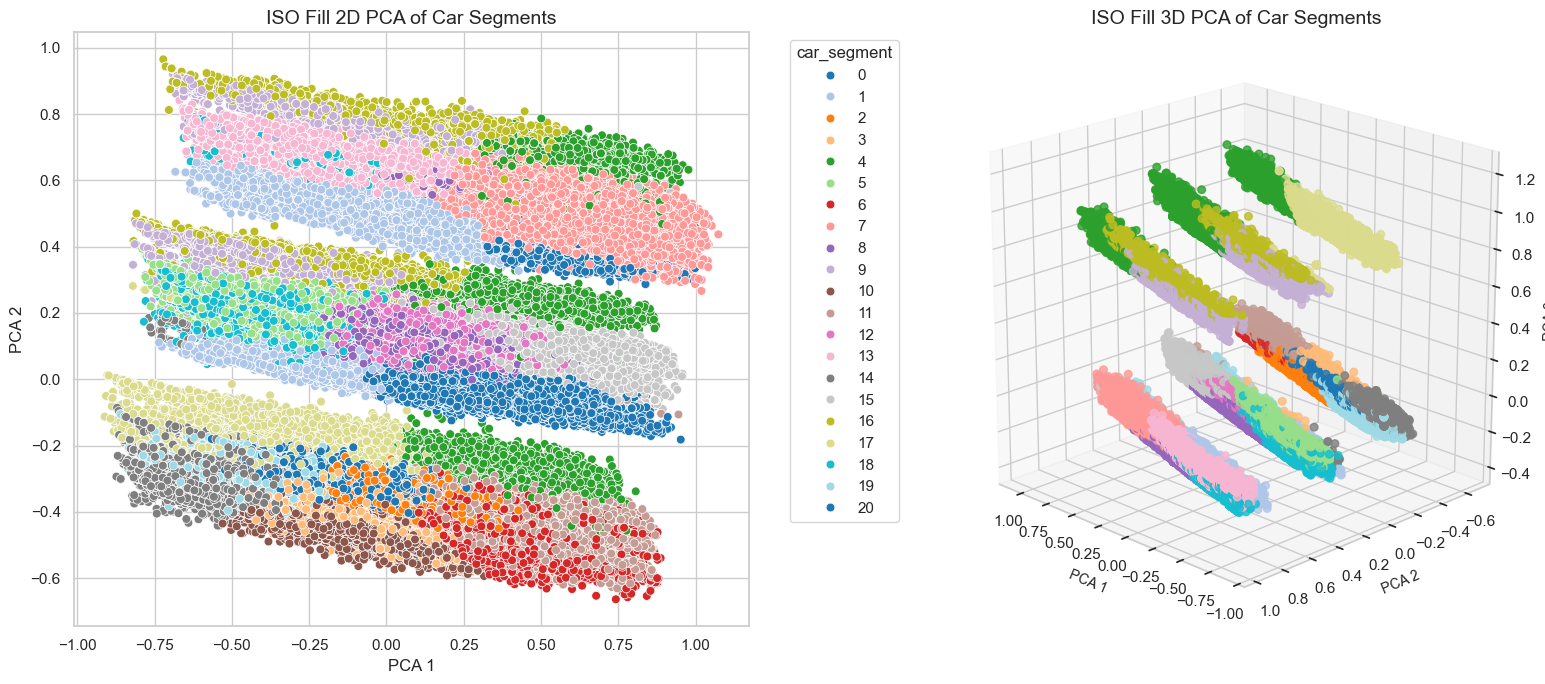

In [31]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_pca_clusters(X_reduced, df_with_labels, title_prefix=''):
    # PCA transformation
    pca_2d = PCA(n_components=2)
    pca_3d = PCA(n_components=3)
    pca_2d_result = pca_2d.fit_transform(X_reduced)
    pca_3d_result = pca_3d.fit_transform(X_reduced)

    # Set theme
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(16, 7))

    # ---------- 2D PCA ----------
    ax1 = fig.add_subplot(1, 2, 1)
    sns.scatterplot(
        x=pca_2d_result[:, 0], y=pca_2d_result[:, 1],
        hue=df_with_labels['car_segment'],
        palette='tab20', s=40, ax=ax1, legend='full'
    )
    ax1.set_title(f'{title_prefix} 2D PCA of Car Segments', fontsize=14)
    ax1.set_xlabel('PCA 1', fontsize=12)
    ax1.set_ylabel('PCA 2', fontsize=12)
    ax1.legend(title='car_segment', bbox_to_anchor=(1.05, 1), loc='upper left')

    # ---------- 3D PCA ----------
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    scatter = ax2.scatter(
        pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2],
        c=df_with_labels['car_segment'], cmap='tab20', s=30, alpha=0.8
    )
    ax2.set_title(f'{title_prefix} 3D PCA of Car Segments', fontsize=14)
    ax2.set_xlabel('PCA 1', fontsize=10)
    ax2.set_ylabel('PCA 2', fontsize=10)
    ax2.set_zlabel('PCA 3', fontsize=10)
    ax2.view_init(elev=20, azim=135)
    ax2.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()

# ------------------------
# Apply clustering & visualize for all 4 sets
# ------------------------

kmeans = KMeans(n_clusters=21, random_state=42)

# Log - Drop
df_cleanwdrop_log['car_segment'] = kmeans.fit_predict(X_log_reduced_cleanwdrop)
visualize_pca_clusters(X_log_reduced_cleanwdrop, df_cleanwdrop_log, title_prefix='Log Drop')

# Log - Fill
df_cleanwfill_log['car_segment'] = kmeans.fit_predict(X_log_reduced_cleanwfill)
visualize_pca_clusters(X_log_reduced_cleanwfill, df_cleanwfill_log, title_prefix='Log Fill')

# ISO - Drop
df_cleanwdrop_iso['car_segment'] = kmeans.fit_predict(X_iso_reduced_cleanwdrop)
visualize_pca_clusters(X_iso_reduced_cleanwdrop, df_cleanwdrop_iso, title_prefix='ISO Drop')

# ISO - Fill
df_cleanwfill_iso['car_segment'] = kmeans.fit_predict(X_iso_reduced_cleanwfill)
visualize_pca_clusters(X_iso_reduced_cleanwfill, df_cleanwfill_iso, title_prefix='ISO Fill')


## 🔐Encoding

In [32]:
df_cleanwdrop_log_encode = df_cleanwdrop_log.copy()
df_cleanwfill_log_encode = df_cleanwfill_log.copy()
df_cleanwdrop_iso_encode = df_cleanwdrop_iso.copy()
df_cleanwfill_iso_encode = df_cleanwfill_iso.copy()

In [33]:
# Define the mappings
title_status_mapping = {
    'clean': 5, 'rebuilt': 4, 'lien': 3,
    'salvage': 2, 'missing': 1, 'parts only': 0
}

condition_mapping = {
    'excellent': 5, 'like new': 4, 'good': 3,
    'fair': 2, 'new': 1, 'salvage': 0
}

cylinder_mapping = {
    '3 cylinders': 3, '4 cylinders': 4, '5 cylinders': 5,
    '6 cylinders': 6, '8 cylinders': 8,
    '10 cylinders': 10, '12 cylinders': 12,
    'other': 0
}

# List of DataFrames to apply the mappings
encoded_dfs = [
    df_cleanwdrop_log_encode,
    df_cleanwdrop_iso_encode
]

encoded_dfsfill = [
    df_cleanwfill_iso_encode,
    df_cleanwfill_log_encode
]

# Apply mappings to each DataFrame
for df in encoded_dfs:
    df['title_status'] = df['title_status'].map(title_status_mapping).fillna(5)
    df['condition'] = df['condition'].map(condition_mapping).fillna(5)
    df['cylinders'] = df['cylinders'].map(cylinder_mapping).fillna(6)

for df in encoded_dfsfill:
    df['title_status'] = df['title_status'].map(title_status_mapping).fillna(5)
    df['condition'] = df['condition'].map(condition_mapping).fillna(5)

In [35]:
categorical_cols = df_cleanwdrop_log_encode.select_dtypes(include='object').columns

for col in categorical_cols:
    le = LabelEncoder()
    df_cleanwdrop_log_encode[col] = le.fit_transform(df_cleanwdrop_log_encode[col].astype(str))

df_cleanwdrop_log_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65722 entries, 0 to 79191
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   region         65722 non-null  int64  
 1   price          65722 non-null  float64
 2   year           65722 non-null  float64
 3   manufacturer   65722 non-null  int64  
 4   model          65722 non-null  int64  
 5   condition      65722 non-null  int64  
 6   cylinders      65722 non-null  int64  
 7   fuel           65722 non-null  int64  
 8   odometer       65722 non-null  float64
 9   title_status   65722 non-null  int64  
 10  transmission   65722 non-null  int64  
 11  drive          65722 non-null  int64  
 12  size           65722 non-null  int64  
 13  type           65722 non-null  int64  
 14  paint_color    65722 non-null  int64  
 15  state          65722 non-null  int64  
 16  posting_year   65722 non-null  int32  
 17  posting_month  65722 non-null  int32  
 18  posting_day

In [36]:
categorical_cols = df_cleanwfill_log_encode.select_dtypes(include='object').columns

for col in categorical_cols:
    le = LabelEncoder()
    df_cleanwfill_log_encode[col] = le.fit_transform(df_cleanwfill_log_encode[col].astype(str))

df_cleanwfill_log_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311396 entries, 0 to 374790
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   region         311396 non-null  int64  
 1   price          311396 non-null  float64
 2   year           311396 non-null  float64
 3   manufacturer   311396 non-null  int64  
 4   model          311396 non-null  int64  
 5   condition      311396 non-null  int64  
 6   cylinders      311396 non-null  int64  
 7   fuel           311396 non-null  int64  
 8   odometer       311396 non-null  float64
 9   title_status   311396 non-null  int64  
 10  transmission   311396 non-null  int64  
 11  drive          311396 non-null  int64  
 12  size           311396 non-null  int64  
 13  type           311396 non-null  int64  
 14  paint_color    311396 non-null  int64  
 15  state          311396 non-null  int64  
 16  matched_make   311396 non-null  int64  
 17  matched_model  311396 non-null  in

In [37]:
categorical_cols = df_cleanwdrop_iso_encode.select_dtypes(include='object').columns

for col in categorical_cols:
    le = LabelEncoder()
    df_cleanwdrop_iso_encode[col] = le.fit_transform(df_cleanwdrop_iso_encode[col].astype(str))

df_cleanwdrop_iso_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69694 entries, 0 to 79191
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   region         69694 non-null  int64  
 1   price          69694 non-null  int64  
 2   year           69694 non-null  float64
 3   manufacturer   69694 non-null  int64  
 4   model          69694 non-null  int64  
 5   condition      69694 non-null  int64  
 6   cylinders      69694 non-null  int64  
 7   fuel           69694 non-null  int64  
 8   odometer       69694 non-null  float64
 9   title_status   69694 non-null  int64  
 10  transmission   69694 non-null  int64  
 11  drive          69694 non-null  int64  
 12  size           69694 non-null  int64  
 13  type           69694 non-null  int64  
 14  paint_color    69694 non-null  int64  
 15  state          69694 non-null  int64  
 16  posting_year   69694 non-null  int32  
 17  posting_month  69694 non-null  int32  
 18  posting_day

In [38]:
categorical_cols = df_cleanwfill_iso_encode.select_dtypes(include='object').columns

for col in categorical_cols:
    le = LabelEncoder()
    df_cleanwfill_iso_encode[col] = le.fit_transform(df_cleanwfill_iso_encode[col].astype(str))

df_cleanwfill_iso_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318296 entries, 0 to 374790
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   region         318296 non-null  int64  
 1   price          318296 non-null  int64  
 2   year           318296 non-null  float64
 3   manufacturer   318296 non-null  int64  
 4   model          318296 non-null  int64  
 5   condition      318296 non-null  int64  
 6   cylinders      318296 non-null  int64  
 7   fuel           318296 non-null  int64  
 8   odometer       318296 non-null  float64
 9   title_status   318296 non-null  int64  
 10  transmission   318296 non-null  int64  
 11  drive          318296 non-null  int64  
 12  size           318296 non-null  int64  
 13  type           318296 non-null  int64  
 14  paint_color    318296 non-null  int64  
 15  state          318296 non-null  int64  
 16  matched_make   318296 non-null  int64  
 17  matched_model  318296 non-null  in

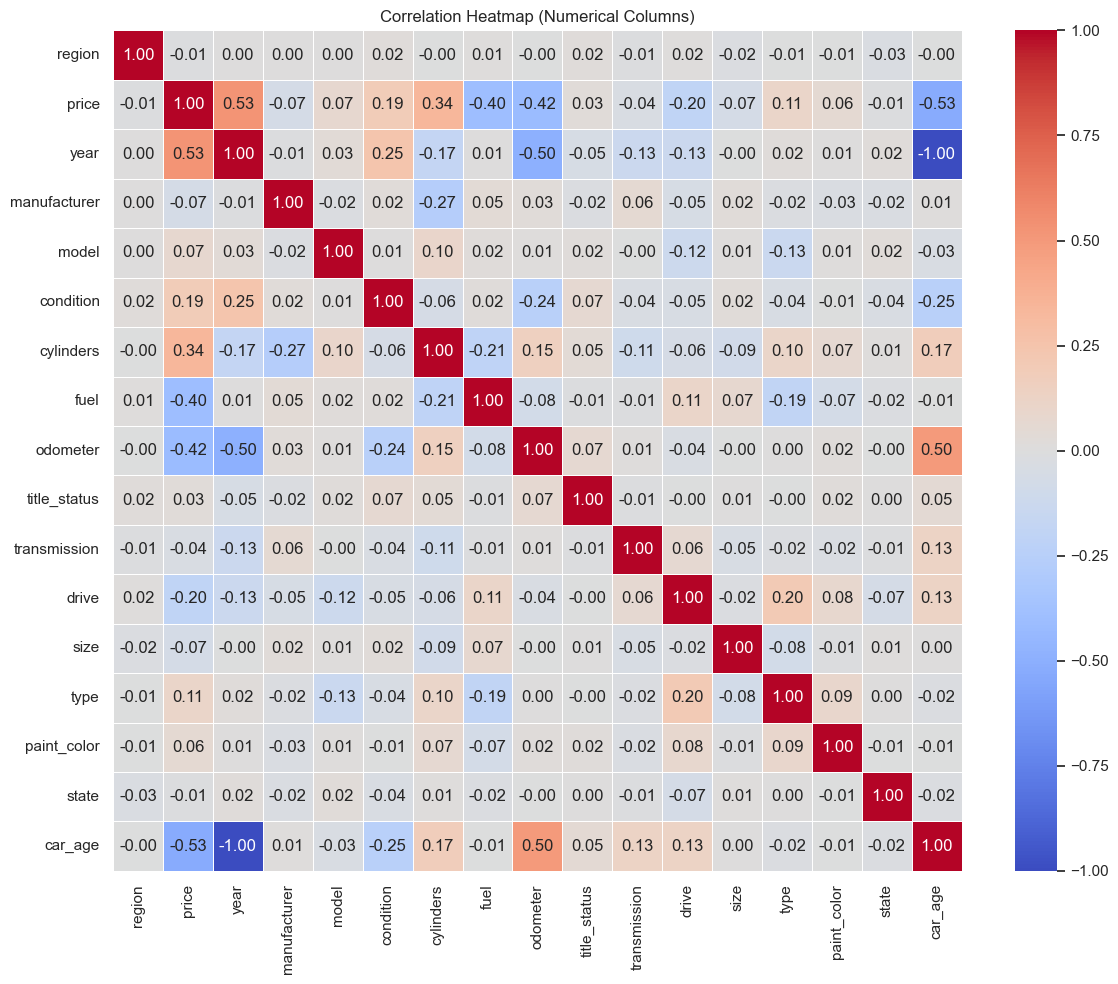

In [39]:
# เลือกเฉพาะคอลัมน์ตัวเลข
numerical_cols = df_cleanwdrop_log_encode.select_dtypes(include=['float64', 'int64'])

# สร้าง correlation matrix
corr = numerical_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Columns)")
plt.tight_layout()
plt.show()

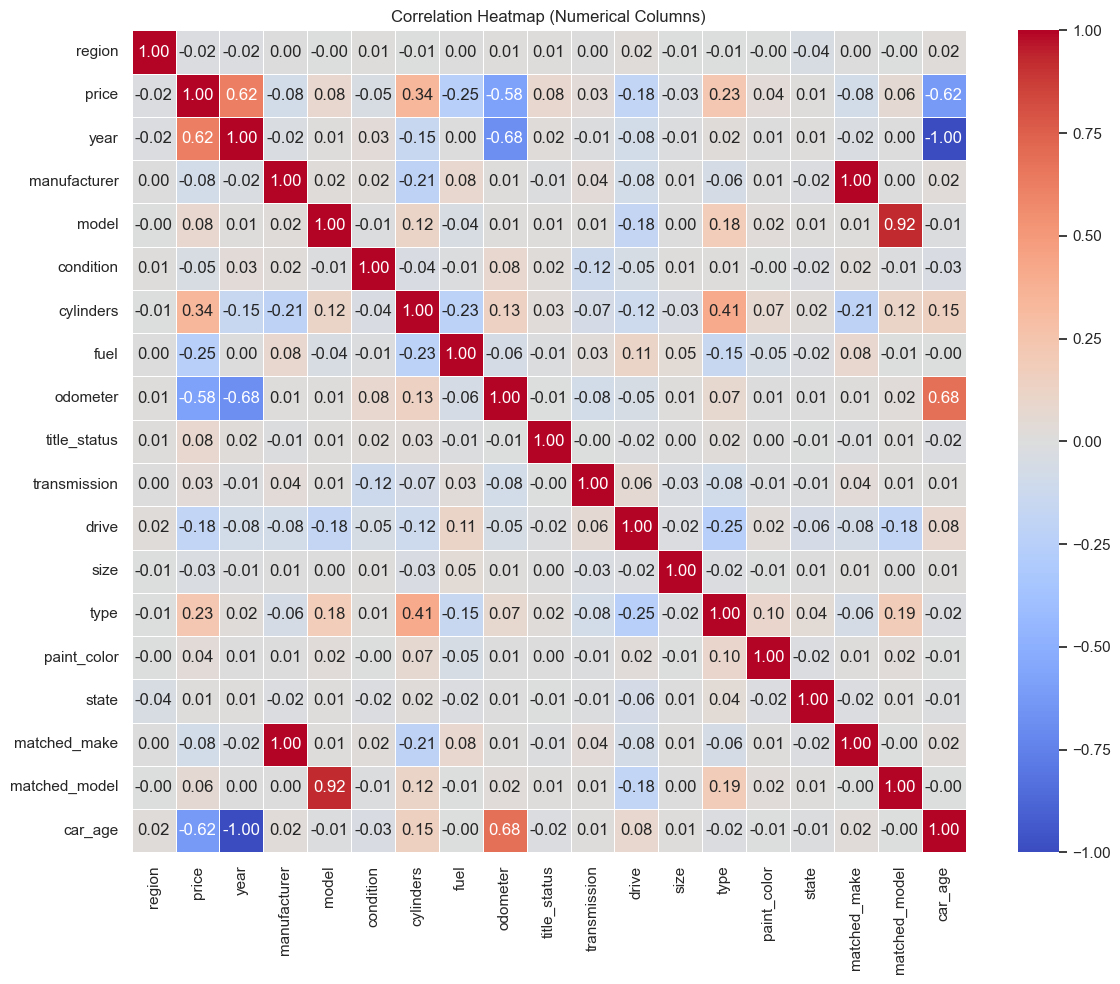

In [40]:
# เลือกเฉพาะคอลัมน์ตัวเลข
numerical_cols = df_cleanwfill_log_encode.select_dtypes(include=['float64', 'int64'])

# สร้าง correlation matrix
corr = numerical_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Columns)")
plt.tight_layout()
plt.show()

In [42]:
#save 4 datasets encoded to /dataset

df_cleanwdrop_log_encode.to_csv('../dataset/cleanedwdrop_log_encode_sales_data.csv', index=False)
df_cleanwfill_log_encode.to_csv('../dataset/cleanedwfill_log_encode_sales_data.csv', index=False)
df_cleanwdrop_iso_encode.to_csv('../dataset/cleanedwdrop_iso_encode_sales_data.csv', index=False)
df_cleanwfill_iso_encode.to_csv('../dataset/cleanedwfill_iso_encode_sales_data.csv', index=False)